In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [27]:
def sigmoid(z):
    """Numerically stable sigmoid function."""
    z = np.clip(z, -500, 500)  # Limit z to avoid overflow
    return np.where(z >= 0,
                    1 / (1 + np.exp(-z)),
                    np.exp(z) / (1 + np.exp(z)))

In [28]:
def cross_entropy(y, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))


In [29]:
def compute_gradients(X, y, y_pred):
    diff = y_pred - y
    return np.dot(X.T, diff) / len(y)

In [30]:
def initialize_weights(size):
    std_dev = np.sqrt(2 / (size + 1))
    return np.random.randn(size) * std_dev

In [36]:
def logistic_regression(X, y, lr, epochs, e=1e-6):
    w = initialize_weights(X.shape[1])
    losses = []
    for epoch in range(epochs):
        z = np.dot(X, w)
        y_pred = sigmoid(z)
        loss = cross_entropy(y, y_pred)
        gradients = compute_gradients(X, y, y_pred)
        w -= lr * gradients
        new_loss = cross_entropy(y, sigmoid(np.dot(X, w)))
        losses.append(new_loss)
        # if epoch % 250 == 0:
        #     print(f'Epoch {epoch}, loss {loss}')
        if np.abs(new_loss - loss) < e:
            print(np.abs(new_loss - loss))
            print(f'Converged at epoch {epoch}')
            break
    return w, losses

In [32]:
def predict_probabilities(X, w):
    z = np.dot(X, w)
    probabilities = sigmoid(z)
    return probabilities

In [33]:
def predict(X, w, threshold=0.5):
    probabilities = predict_probabilities(X, w)
    return (probabilities >= threshold).astype(int)

FOR THE MATCH_DATA BEST PARAMETERS ARE EPOCHS = 4000 AND LR=0.01

In [40]:
df = pd.read_csv('../data/match_data.csv')
X = df.drop(columns=['Date', 'Team1', 'Team2', 'Score'])
y = df['Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

FOR ROUNDS DATA BEST PARAMETERS ARE EPOCHS = 1000 AND LR=0.01

In [44]:
df = pd.read_csv('../data/cleaned_rounds_data.csv')
df = df.drop(columns=[f'player_{i}_{suffix}' for i in range(1, 11) for suffix in ['team_name', 'name']])
X = df.drop(['round_winner'], axis=1)
y = df['round_winner']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

FOR ROUNDS DATA WITH STATS BEST PARAMETERS ARE EPOCHS = 1500 AND LR=0.01

In [47]:
df = pd.read_csv('../data/cleaned_rounds_data_with_stats.csv')
df = df.drop(columns=[f'player_{i}_{suffix}' for i in range(1, 11) for suffix in ['team_name', 'name']])
X = df.drop(['round_winner'], axis=1)
y = df['round_winner']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [48]:
epochs_vec = [1000, 2000, 3000, 4000, 5000]
lr_vec = [0.001, 0.01, 0.1]
best_epoch = None
best_lr = None
best_auc = -np.inf

for epochs in epochs_vec:
    for lr in lr_vec:
        w, losses = logistic_regression(X_train, y_train, lr, epochs)
        y_prob = predict_probabilities(X_test, w)
        auc_score = roc_auc_score(y_test, y_prob)
        print(f'ROC-AUC with {epochs} epochs and learning rate {lr}: {auc_score}')
        if auc_score > best_auc:
            best_auc = auc_score
            best_epoch = epochs
            best_lr = lr

print(f'Best ROC-AUC: {best_auc} with {best_epoch} epochs and learning rate {best_lr}')
        

ROC-AUC with 1000 epochs and learning rate 0.001: 0.6923648004065732
ROC-AUC with 1000 epochs and learning rate 0.01: 0.8192318501019664
ROC-AUC with 1000 epochs and learning rate 0.1: 0.8163989736610325
ROC-AUC with 2000 epochs and learning rate 0.001: 0.7674545996825801
ROC-AUC with 2000 epochs and learning rate 0.01: 0.8181152811664862
9.99652406630247e-07
Converged at epoch 1306
ROC-AUC with 2000 epochs and learning rate 0.1: 0.8155381280834852
ROC-AUC with 3000 epochs and learning rate 0.001: 0.7905579937506595
ROC-AUC with 3000 epochs and learning rate 0.01: 0.8185004812982778
9.991353200899944e-07
Converged at epoch 1295
ROC-AUC with 3000 epochs and learning rate 0.1: 0.8158592627845529
ROC-AUC with 4000 epochs and learning rate 0.001: 0.8032375653844248
9.99463118211974e-07
Converged at epoch 3427
ROC-AUC with 4000 epochs and learning rate 0.01: 0.8193077595619002
9.988991658271829e-07
Converged at epoch 1187
ROC-AUC with 4000 epochs and learning rate 0.1: 0.8155992325069072
RO

              precision    recall  f1-score   support

           0       0.60      0.58      0.59       426
           1       0.59      0.61      0.60       418

    accuracy                           0.59       844
   macro avg       0.59      0.59      0.59       844
weighted avg       0.59      0.59      0.59       844

                 Predicted Negative  Predicted Positive
Actual Negative                 246                 180
Actual Positive                 163                 255
ROC-AUC Score: 0.6356560415122312


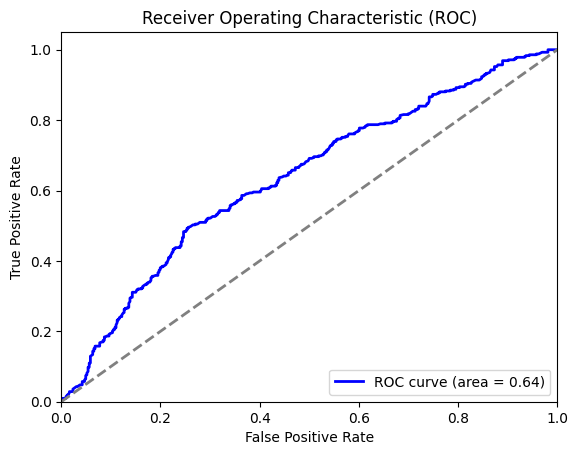

In [42]:
# STATISTICS FOR MATCH DATA WITH BEST PARAMETERS

              precision    recall  f1-score   support

           0       0.76      0.74      0.75      1864
           1       0.76      0.78      0.77      1993

    accuracy                           0.76      3857
   macro avg       0.76      0.76      0.76      3857
weighted avg       0.76      0.76      0.76      3857

                 Predicted Negative  Predicted Positive
Actual Negative                1379                 485
Actual Positive                 447                1546
ROC-AUC Score: 0.8219086007033201


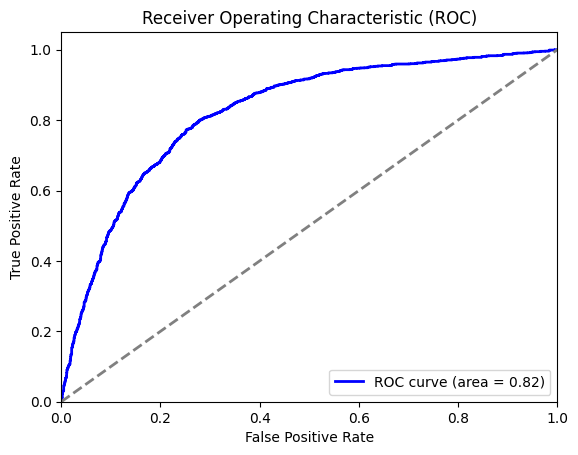

In [46]:
# STATISTICS FOR ROUNDS DATA WITH BEST PARAMETERS

9.995766889758784e-07
Converged at epoch 3384
              precision    recall  f1-score   support

           0       0.75      0.74      0.75      1864
           1       0.76      0.77      0.77      1993

    accuracy                           0.76      3857
   macro avg       0.76      0.76      0.76      3857
weighted avg       0.76      0.76      0.76      3857

                 Predicted Negative  Predicted Positive
Actual Negative                1375                 489
Actual Positive                 449                1544
ROC-AUC Score: 0.8177637288449486


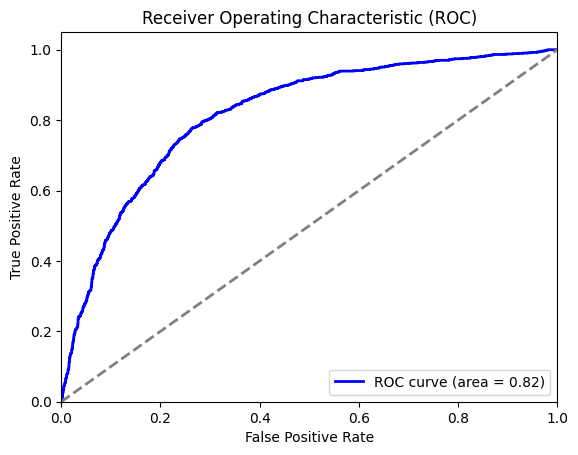

In [50]:
w, losses = logistic_regression(X_train, y_train, best_lr, epochs=best_epoch)
y_pred = predict(X_test, w)
y_prob = predict_probabilities(X_test, w)

print(classification_report(y_test, y_pred))
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(confusion_matrix, index=['Actual Negative', 'Actual Positive'],
                              columns=['Predicted Negative', 'Predicted Positive'])
print(conf_matrix_df)

roc_auc = roc_auc_score(y_test, y_prob)
print(f'ROC-AUC Score: {roc_auc}')
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()